In [1]:
import numpy as np
import librosa
import librosa.display as display
import matplotlib.pyplot as plt
import os
import h5py
import time
from IPython.display import Audio
from config import PARAS



MIX_PATH = '../DSD100/Mixtures'
SRC_PATH = '../DSD100/Sources'

# Get File Paths

- Path Dictionary
    - Music File Index
        - Track 1 -> path
        - Track 2 -> path

In [2]:
dev_file_paths = dict()
test_file_paths = dict()

for (dirpath, dirnames, filenames) in os.walk(MIX_PATH):
    if not dirnames:
        if 'Test' in dirpath:
            file_name = dirpath.split('Test/')[-1].split('-')[0].strip()
            test_file_paths[file_name] = dict()
            test_file_paths[file_name]['mix'] = dirpath + '/' + filenames[0]
        elif 'Dev' in dirpath:
            file_name = dirpath.split('Dev/')[-1].split('-')[0].strip()
            dev_file_paths[file_name] = dict()
            dev_file_paths[file_name]['mix'] = dirpath + '/' + filenames[0]

for (dirpath, dirnames, filenames) in os.walk(SRC_PATH):

    if not dirnames:
        if 'Test' in dirpath:
            file_name = dirpath.split('Test/')[-1].split('-')[0].strip()
            for trackname in filenames:
                track = trackname.split('.wav')[0]
                test_file_paths[file_name][track] = dirpath + '/' + trackname
        elif 'Dev' in dirpath:
            file_name = dirpath.split('Dev/')[-1].split('-')[0].strip()
            for trackname in filenames:
                track = trackname.split('.wav')[0]
                dev_file_paths[file_name][track] = dirpath + '/' + trackname
    

# Build Feature Extractor

In [3]:
PARAS.SR, PARAS.N_FFT, PARAS.N_MEL, PARAS.SAMPLE_TIME

(16000, 512, 150, 1)

In [4]:
test_path = test_file_paths['001']
test_path, len(dev_file_paths)

({'mix': '../DSD100/Mixtures/Test/001 - ANiMAL - Clinic A/mixture.wav',
  'drums': '../DSD100/Sources/Test/001 - ANiMAL - Clinic A/drums.wav',
  'vocals': '../DSD100/Sources/Test/001 - ANiMAL - Clinic A/vocals.wav',
  'other': '../DSD100/Sources/Test/001 - ANiMAL - Clinic A/other.wav',
  'bass': '../DSD100/Sources/Test/001 - ANiMAL - Clinic A/bass.wav'},
 50)

## The Points
- Do not use the origin mix track, using the sum of vocal and background tracks and return a new mixed track, because the old track is not ensured the normalization
### Remove vocal silence part ( slience is useless for model training)

In [5]:
def remove_silence(vocal, target_track):
    """
    This function remove slience part
    notice it's not an in place dealer
    """
    remove_list = list()
    for i, point in enumerate(vocal):
        if 0 == point:
            remove_list.append(i)
    vocal_out = np.delete(vocal, remove_list)
    target_track_out = np.delete(target_track, remove_list)
    return vocal_out, target_track_out

### Extract the mix/target signals

In [6]:
def sound_tracks_extractor(file_path):
    """
    Take in a file path dictionary, return:
    (Normalized track)
    vocal track as target
    mixed track as input
    """
    signals = dict()
    for key in file_path:
        if key == 'mix':
            continue
        signals[key], _ = librosa.load(file_path.get(key), sr = PARAS.SR)
        signals[key] = librosa.util.normalize(signals.get(key))
        
    vocal_track = signals.get('vocals')
    return_vocal, _ = remove_silence(vocal_track, vocal_track)
    mix_track = np.zeros(len(return_vocal))

    for key in signals:
        if 'vocals' == key:
            continue
        _, signals[key] = remove_silence(vocal_track, signals.get(key))
        mix_track = signals.get(key) if not len(mix_track) else mix_track + signals.get(key)
    
    mix_track = mix_track + return_vocal
    
    return return_vocal, mix_track

In [7]:
b = sound_tracks_extractor(test_file_paths['001'])

In [8]:
Audio(b[1], rate=PARAS.SR)

### Generate chunks Spectrogram
#### Create 1s chunks (backup)

In [9]:
def signal_divider(signal, sr=PARAS.SR, time=PARAS.SAMPLE_TIME):
    """
    This one takes signal in and devided them in 1s frames
    """
    sample_length = sr * time
    n_frames = len(signal) // sample_length
    new_list = list()
    for i in range(n_frames):
        new_list.append(signal[i*sample_length:(i+1)*sample_length])
    return new_list

#### create mel_spectrogram (150 * 150 frames)

In [10]:
def frame_feature_extractor(signal):
    """
    Takes in new signals and create mel chunks 
    """
    S = librosa.feature.melspectrogram(y=signal, sr=PARAS.SR, n_mels=PARAS.N_MEL).T
    S = librosa.power_to_db(S)
    S = S[:-1 * (S.shape[0] % PARAS.N_MEL)] # divide the mel spectrogram
    chunk_num = S.shape[0] // PARAS.N_MEL
    mel_chunks = np.split(S, chunk_num) # create 128 * 128 data frames
    return mel_chunks, chunk_num

In [23]:
vocal_ct, chunk_n = frame_feature_extractor(b[0])
mix_ct, _ = frame_feature_extractor(b[1])

In [24]:
vocal_ct[0].shape, mix_ct[0].shape

((150, 150), (150, 150))

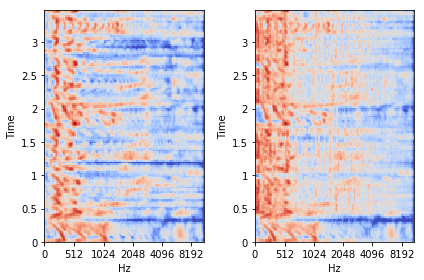

In [29]:
plt.figure()
plt.subplot(1, 2, 1)
librosa.display.specshow(vocal_ct[0], x_axis='mel', y_axis='time')
plt.subplot(1, 2, 2)
librosa.display.specshow(mix_ct[0], x_axis='mel', y_axis='time')
plt.tight_layout()

plt.show()


# Build dataset

In [67]:
data_set_path = PARAS.DATASET_PATH + 'all.h5'
dataset = h5py.File(data_set_path, 'a')

In [68]:
len(dev_file_paths), len(test_file_paths), chunk_n

(50, 50, 36)

In [69]:
file_paths = dict(list(dev_file_paths.items())
                  + list(test_file_paths.items()))

## load data
One $ for one file. (100 in total)

In [74]:
vocal_tmp = list()
mix_tmp = list()

In [ ]:
print("start loading data: $", end="")
for key, file_dict in file_paths.items():
    vocal_signal, mix_signal = sound_tracks_extractor(file_dict)
    vocal_chunks, cn = frame_feature_extractor(vocal_signal)
    mix_chunks, _ = frame_feature_extractor(mix_signal)
    for idx in range(cn):
        vocal_tmp.append(mix_chunks[idx])
        mix_tmp.append(vocal_chunks[idx])
    print("=>${0}".format(key), end="")

start loading data: $=>$071

In [73]:
dataset.create_dataset('mix', 
                       shape=(-1, 150, 150), 
                       dtype=np.float32)

dataset.create_dataset('vocal', 
                       shape=(-1, 150, 150), 
                       dtype=np.float32)

OverflowError: can't convert negative value to hsize_t